In [115]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import DBLP
from torch_geometric.transforms import NormalizeFeatures
import random
from collections import defaultdict
import copy
import ast
import csv
import numpy as np

dataset = DBLP(root='../data/DBLP', transform=NormalizeFeatures())
hetero_data = dataset[0]

In [116]:
def convert_to_author_graph(hetero_data):    
    # Initialize adjacency list to count co-authorship
    adj_dict = defaultdict(int)
    
    # Process 'writes' and 'written_by' edges to count co-authorships
    author_to_paper = hetero_data['author', 'to', 'paper'].edge_index
    paper_to_author = hetero_data['paper', 'to', 'author'].edge_index
    
    for author, paper in author_to_paper.t().tolist():
        coauthors = paper_to_author[1, paper_to_author[0] == paper].tolist()
        for coauthor in coauthors:
            if author != coauthor:
                edge = tuple([author, coauthor])
                adj_dict[edge] += 1
    
    # Create edge_index and edge_weight tensors
    edge_index = torch.tensor(list(adj_dict.keys()), dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(list(adj_dict.values()), dtype=torch.float)
    
    # Create the homogeneous graph
    data = Data()
    data.x = hetero_data['author'].x
    data.edge_index = edge_index
    data.edge_weight = edge_weight

    data.train_mask = hetero_data['author'].train_mask
    data.val_mask = hetero_data['author'].val_mask
    data.test_mask = hetero_data['author'].test_mask
    data.y = hetero_data['author'].y
    
    return data

# Convert the dataset
data = convert_to_author_graph(hetero_data)

In [117]:
GCN_GNNExplainer_explanations = {}
GCN_IG_explanations = {}
GAT_GNNExplainer_explanations = {}
GAT_IG_explanations = {}

with open("../results/Explanations_GCN_GNNExplainer_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GCN_GNNExplainer_explanations[index] = (edge_indices_list, edge_weights_list)

with open("../results/Explanations_GCN_IntegratedGradients_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GCN_IG_explanations[index] = (edge_indices_list, edge_weights_list)

with open("../results/Explanations_GAT_GNNExplainer_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GAT_GNNExplainer_explanations[index] = (edge_indices_list, edge_weights_list)

with open("../results/Explanations_GAT_IntegratedGradients_DBLP.csv", mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
    for row in reader:
        if row:
            index = row[0]
            edge_indices = row[3]
            edge_indices_list = ast.literal_eval(edge_indices)
            edge_weights = row[4]
            edge_weights_list = ast.literal_eval(edge_weights)
            GAT_IG_explanations[index] = (edge_indices_list, edge_weights_list)

In [118]:
def get_edge_frequencies(data, explanations, significant_node_masks):
    edge_frequencies_big = defaultdict(int)
    edge_frequencies_small = defaultdict(int)

    for i, (edge_indices, edge_weights) in explanations.items():
        edge_indices = torch.tensor(edge_indices)
        edge_weights = torch.tensor(edge_weights)

        significant_edge_mask_big = edge_indices[edge_weights > significant_node_masks[0]].to(torch.int64)
        significant_edge_mask_small = edge_indices[edge_weights > significant_node_masks[1]].to(torch.int64)

        significant_edge_index_big = data.edge_index[:, significant_edge_mask_big]
        significant_edge_index_small = data.edge_index[:, significant_edge_mask_small]

        for j in range(significant_edge_index_big.shape[1]):
            edge = tuple(sorted((significant_edge_index_big[0, j].item(), significant_edge_index_big[1, j].item())))
            edge_frequencies_big[edge] += 1

        for j in range(significant_edge_index_small.shape[1]):
            edge = tuple(sorted((significant_edge_index_small[0, j].item(), significant_edge_index_small[1, j].item())))
            edge_frequencies_small[edge] += 1

    return edge_frequencies_big, edge_frequencies_small


GCN_GNNExplainer_edge_freq_big, GCN_GNNExplainer_edge_freq_small = get_edge_frequencies(data, GCN_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GCN_IG_edge_freq_big, GCN_IG_edge_freq_small = get_edge_frequencies(data, GCN_IG_explanations, significant_node_masks=(0.01, 0.0001))
GAT_GNNExplainer_edge_freq_big, GAT_GNNExplainer_edge_freq_small = get_edge_frequencies(data, GAT_GNNExplainer_explanations, significant_node_masks=(0.3, 0.1))
GAT_IG_edge_freq_big, GAT_IG_edge_freq_small = get_edge_frequencies(data, GAT_IG_explanations, significant_node_masks=(0.01, 0.0001))

In [119]:
def divide_into_chunks(freq, n):
    lst = sorted(freq.items(), key=lambda x: x[1])
    """Divide the list lst into n equally-sized chunks."""
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


num_bins = 10
GCN_GNNExplainer_bins_big = divide_into_chunks(GCN_GNNExplainer_edge_freq_big, num_bins)
GCN_GNNExplainer_bins_small = divide_into_chunks(GCN_GNNExplainer_edge_freq_small, num_bins)
GCN_IG_bins_big = divide_into_chunks(GCN_IG_edge_freq_big, num_bins)
GCN_IG_bins_small = divide_into_chunks(GCN_IG_edge_freq_small, num_bins)
GAT_GNNExplainer_bins_big = divide_into_chunks(GAT_GNNExplainer_edge_freq_big, num_bins)
GAT_GNNExplainer_bins_small = divide_into_chunks(GAT_GNNExplainer_edge_freq_small, num_bins)
GAT_IG_bins_big = divide_into_chunks(GAT_IG_edge_freq_big, num_bins)
GAT_IG_bins_small = divide_into_chunks(GAT_IG_edge_freq_small, num_bins)

In [120]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features['author'], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.y.max().item() + 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x

GCN_model = GCN(hidden_channels=16)

In [121]:
GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def GCN_train():
    GCN_model.train()
    GCN_optimizer.zero_grad()  # Clear gradients.
    out = GCN_model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    GCN_optimizer.step()  # Update parameters based on gradients.
    return loss

def GCN_test(mask):
    GCN_model.eval()
    out = GCN_model(data.x, data.edge_index, data.edge_weight)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [122]:
for epoch in range(1, 101):
    loss = GCN_train()
    val_acc = GCN_test(data.val_mask)
    test_acc = GCN_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.3844, Val: 0.3500, Test: 0.4019
Epoch: 002, Loss: 1.3736, Val: 0.4100, Test: 0.4498
Epoch: 003, Loss: 1.3636, Val: 0.4100, Test: 0.4639
Epoch: 004, Loss: 1.3547, Val: 0.3975, Test: 0.4566
Epoch: 005, Loss: 1.3377, Val: 0.4025, Test: 0.4566
Epoch: 006, Loss: 1.3269, Val: 0.4100, Test: 0.4645
Epoch: 007, Loss: 1.3163, Val: 0.4100, Test: 0.4725
Epoch: 008, Loss: 1.3006, Val: 0.4250, Test: 0.4900
Epoch: 009, Loss: 1.2874, Val: 0.4275, Test: 0.5045
Epoch: 010, Loss: 1.2773, Val: 0.4500, Test: 0.5204
Epoch: 011, Loss: 1.2594, Val: 0.4600, Test: 0.5355
Epoch: 012, Loss: 1.2520, Val: 0.4775, Test: 0.5662
Epoch: 013, Loss: 1.2318, Val: 0.5025, Test: 0.5944
Epoch: 014, Loss: 1.2120, Val: 0.5200, Test: 0.6095
Epoch: 015, Loss: 1.2019, Val: 0.5475, Test: 0.6313
Epoch: 016, Loss: 1.1821, Val: 0.5675, Test: 0.6494
Epoch: 017, Loss: 1.1694, Val: 0.5875, Test: 0.6592
Epoch: 018, Loss: 1.1550, Val: 0.5950, Test: 0.6690
Epoch: 019, Loss: 1.1522, Val: 0.6050, Test: 0.6739
Epoch: 020, 

In [123]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features['author'], hidden_channels, heads=heads, edge_dim=1)
        self.conv2 = GATConv(hidden_channels * heads, data.y.max().item() + 1, edge_dim=1)

    def forward(self, x, edge_index, edge_weight):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index, edge_attr=edge_weight)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        return x

GAT_model = GAT(hidden_channels=8, heads=8)
print(GAT_model)

GAT(
  (conv1): GATConv(334, 8, heads=8)
  (conv2): GATConv(64, 4, heads=1)
)


In [93]:
GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def GAT_train():
    GAT_model.train()
    GAT_optimizer.zero_grad()
    out = GAT_model(data.x, data.edge_index, data.edge_weight)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    GAT_optimizer.step()
    return loss

def GAT_test(mask):
    GAT_model.eval()
    out = GAT_model(data.x, data.edge_index, data.edge_weight)
    out = F.softmax(out, dim=1)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [94]:
for epoch in range(1, 101):
    loss = GAT_train()
    val_acc = GAT_test(data.val_mask)
    test_acc = GAT_test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.3880, Val: 0.3075, Test: 0.3344
Epoch: 002, Loss: 1.3750, Val: 0.3550, Test: 0.3896
Epoch: 003, Loss: 1.3578, Val: 0.3900, Test: 0.4289
Epoch: 004, Loss: 1.3491, Val: 0.4050, Test: 0.4587
Epoch: 005, Loss: 1.3284, Val: 0.4250, Test: 0.4768
Epoch: 006, Loss: 1.3129, Val: 0.4425, Test: 0.4919
Epoch: 007, Loss: 1.3036, Val: 0.4550, Test: 0.5069
Epoch: 008, Loss: 1.2977, Val: 0.4650, Test: 0.5210
Epoch: 009, Loss: 1.2852, Val: 0.4650, Test: 0.5293
Epoch: 010, Loss: 1.2758, Val: 0.4675, Test: 0.5398
Epoch: 011, Loss: 1.2572, Val: 0.4750, Test: 0.5484
Epoch: 012, Loss: 1.2564, Val: 0.4800, Test: 0.5545
Epoch: 013, Loss: 1.2288, Val: 0.4825, Test: 0.5625
Epoch: 014, Loss: 1.2202, Val: 0.4900, Test: 0.5723
Epoch: 015, Loss: 1.2186, Val: 0.5000, Test: 0.5867
Epoch: 016, Loss: 1.2062, Val: 0.5150, Test: 0.6024
Epoch: 017, Loss: 1.1841, Val: 0.5350, Test: 0.6196
Epoch: 018, Loss: 1.1673, Val: 0.5425, Test: 0.6349
Epoch: 019, Loss: 1.1660, Val: 0.5575, Test: 0.6494
Epoch: 020, 

In [95]:
def generate_perturbations(data, edges_to_remove):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    
    edges_set = set(map(tuple, edges.numpy()))
    remove_set = set(map(tuple, edges_to_remove.numpy()))

    keep_edges = edges_set - remove_set
    keep_edges = torch.tensor(list(keep_edges)).t()

    # Create a mask to keep track of which edges are kept
    keep_edges_set = set(map(tuple, keep_edges.t().numpy()))
    edge_mask = torch.tensor([tuple(edge.numpy()) in keep_edges_set for edge in edges], dtype=torch.bool)
    
    data.edge_index = keep_edges
    data.edge_weight = data.edge_weight[edge_mask]
    
    return data


def make_undirected(lst):
    lst = torch.tensor(lst)
    flipped = lst.flip(dims=[1])
    combined = torch.cat((lst, flipped), dim=0)
    return combined


def calc_rrmse(y, y_hat):
    residuals = y - y_hat
    squared_norm_residuals = torch.linalg.vector_norm(residuals)**2
    squared_norm_orig = torch.linalg.vector_norm(y_hat)**2
    return torch.sqrt(squared_norm_residuals / squared_norm_orig)


def get_logit_diff(model, perturbed_data):
    model.eval()
    with torch.no_grad():
        out_orig = model(data.x, data.edge_index, data.edge_weight)
        out_perturb = model(perturbed_data.x, perturbed_data.edge_index, perturbed_data.edge_weight)
        return calc_rrmse(out_orig, out_perturb)

In [96]:
num_samples = 10

GCN_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GCN_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GCN_IG_results_small = torch.zeros(num_bins, num_samples)
GCN_IG_results_big = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_small = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_big = torch.zeros(num_bins, num_samples)
GAT_IG_results_small = torch.zeros(num_bins, num_samples)
GAT_IG_results_big = torch.zeros(num_bins, num_samples)

GCN_GNNExplainer_avg_freq_small = []
GCN_GNNExplainer_avg_freq_big = []
GCN_IG_avg_freq_small = []
GCN_IG_avg_freq_big = []
GAT_GNNExplainer_avg_freq_small = []
GAT_GNNExplainer_avg_freq_big = []
GAT_IG_avg_freq_small = []
GAT_IG_avg_freq_big = []


def populate_result_tensors(bins, model, avg_freq, res, perturb_size):
    for i, bin in enumerate(bins):
        avg_freq.append(np.mean([i[1] for i in bin]))
        for j in range(num_samples):
            edges = [i[0] for i in bin]
            sampled_edges = random.sample(edges, perturb_size)
            edges_to_remove = make_undirected(sampled_edges)
            perturbed_data = generate_perturbations(data, edges_to_remove)
            res[i, j] = get_logit_diff(model, perturbed_data)


perturb_size_small = len(GCN_GNNExplainer_bins_small[0]) // 2
perturb_size_big = len(GCN_GNNExplainer_bins_big[0]) // 2

populate_result_tensors(GCN_GNNExplainer_bins_small, GCN_model, GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small, perturb_size_small)
populate_result_tensors(GCN_GNNExplainer_bins_big, GCN_model, GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big, perturb_size_big)
populate_result_tensors(GCN_IG_bins_small, GCN_model, GCN_IG_avg_freq_small, GCN_IG_results_small, perturb_size_small)
populate_result_tensors(GCN_IG_bins_big, GCN_model, GCN_IG_avg_freq_big, GCN_IG_results_big, perturb_size_big)
populate_result_tensors(GAT_GNNExplainer_bins_small, GAT_model, GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small, perturb_size_small)
populate_result_tensors(GAT_GNNExplainer_bins_big, GAT_model, GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big, perturb_size_big)
populate_result_tensors(GAT_IG_bins_small, GAT_model, GAT_IG_avg_freq_small, GAT_IG_results_small, perturb_size_small)
populate_result_tensors(GAT_IG_bins_big, GAT_model, GAT_IG_avg_freq_big, GAT_IG_results_big, perturb_size_big)

In [97]:
GCN_baseline_big = torch.zeros(num_samples)
GCN_baseline_small = torch.zeros(num_samples)
GAT_baseline_big = torch.zeros(num_samples)
GAT_baseline_small = torch.zeros(num_samples)


def populate_baseline_tensors(freq, model, res, perturb_size):
    for i in range(num_samples):
        edges = [i[0] for i in freq.items()]
        sampled_edges = random.sample(edges, perturb_size)
        edges_to_remove = make_undirected(sampled_edges)
        perturbed_data = generate_perturbations(data, edges_to_remove)
        res[i] = get_logit_diff(model, perturbed_data)


populate_baseline_tensors(GCN_GNNExplainer_edge_freq_big, GCN_model, GCN_baseline_big, perturb_size_big)
populate_baseline_tensors(GCN_GNNExplainer_edge_freq_small, GCN_model, GCN_baseline_small, perturb_size_small)
populate_baseline_tensors(GAT_GNNExplainer_edge_freq_big, GAT_model, GAT_baseline_big, perturb_size_big)
populate_baseline_tensors(GAT_GNNExplainer_edge_freq_small, GAT_model, GAT_baseline_small, perturb_size_small)

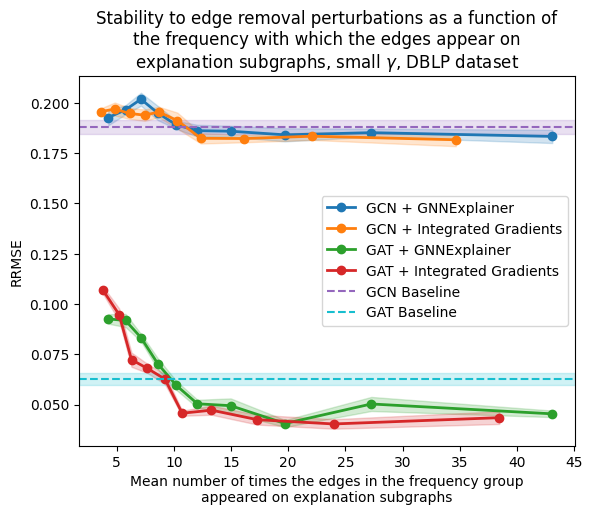

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_with_confidence_intervals(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)
    sem_values = sem(results, axis=1)  # SEM is standard error of the mean

    # Calculate the confidence intervals (95% confidence level)
    ci_lower = mean_values - 1.96 * sem_values
    ci_upper = mean_values + 1.96 * sem_values

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')

    # Plot the confidence intervals as shaded areas
    plt.fill_between(avg_freq, ci_lower, ci_upper, color=color, alpha=0.2)


def plot_baseline(baseline, label, color):
    mean = np.mean(baseline)
    sem_baseline = sem(baseline)

    ci_lower = mean - 1.96 * sem_baseline
    ci_upper = mean + 1.96 * sem_baseline

    plt.axhline(y=mean, color=color, linestyle='--', label=label)
    plt.fill_between([0, 1], ci_lower, ci_upper, color=color, alpha=0.2, transform=plt.gca().get_yaxis_transform())


plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_small, GCN_IG_results_small.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_small, GAT_IG_results_small.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_small.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_small.numpy(), "GAT Baseline", colors[5])
# plot_with_confidence_intervals(tagcn_avg_freq_small, tagcn_results_small.numpy(), 'TAGCN', colors[2])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to edge removal perturbations as a function of\nthe frequency with which the edges appear on\nexplanation subgraphs, small $\\gamma$, DBLP dataset')
plt.show()

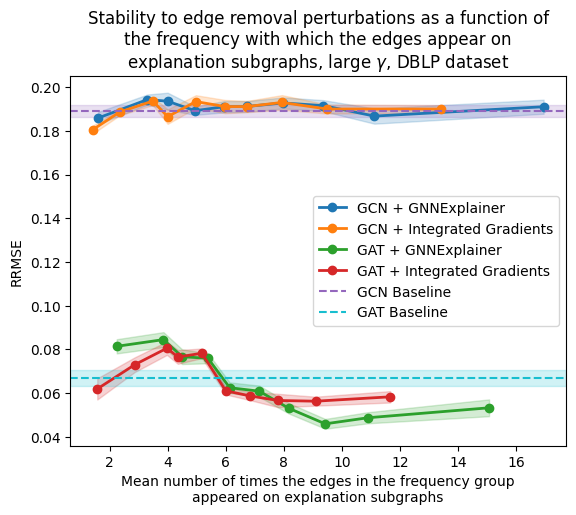

In [99]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_big, GCN_IG_results_big.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_big, GAT_IG_results_big.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_big.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_big.numpy(), "GAT Baseline", colors[5])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to edge removal perturbations as a function of\nthe frequency with which the edges appear on\nexplanation subgraphs, large $\\gamma$, DBLP dataset')
plt.show()

In [100]:
def generate_edge_weight_perturbations(data, edges_to_perturb, max_change=20):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    edge_weights = data.edge_weight.clone()
    
    edges_to_perturb_set = set(map(tuple, edges_to_perturb.numpy()))

    perturbed_indices = []
    perturbed_weights = []

    # Identify perturbed edges and store their original weights
    for idx, edge in enumerate(edges):
        if tuple(edge.numpy()) in edges_to_perturb_set:
            perturbed_indices.append(idx)
            perturbed_weights.append(edge_weights[idx])

    # Compute original norm of perturbed weights
    original_norm = torch.norm(torch.tensor(perturbed_weights), p=2)

    # Apply perturbations
    for idx in perturbed_indices:
        change = max_change * (2 * torch.rand(1) - 1)  # Uniform distribution from -max_change to +max_change
        new_weight = edge_weights[idx] + change
        edge_weights[idx] = abs(new_weight)  # Ensure no negative weights

    # Calculate norm of perturbed weights
    perturbed_new_weights = edge_weights[perturbed_indices]
    current_norm = torch.norm(perturbed_new_weights, p=2)

    # Renormalize only perturbed edge weights
    renormalization_factor = original_norm / current_norm
    edge_weights[perturbed_indices] *= renormalization_factor

    print(torch.norm(edge_weights))

    data.edge_weight = edge_weights
    
    return data

In [101]:
num_samples = 10

GCN_GNNExplainer_results_small_edge_weights = torch.zeros(num_bins, num_samples)
GCN_GNNExplainer_results_big_edge_weights = torch.zeros(num_bins, num_samples)
GCN_IG_results_small_edge_weights = torch.zeros(num_bins, num_samples)
GCN_IG_results_big_edge_weights = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_small_edge_weights = torch.zeros(num_bins, num_samples)
GAT_GNNExplainer_results_big_edge_weights = torch.zeros(num_bins, num_samples)
GAT_IG_results_small_edge_weights = torch.zeros(num_bins, num_samples)
GAT_IG_results_big_edge_weights = torch.zeros(num_bins, num_samples)


def populate_result_tensors_edge_weights(bins, model, res):
    for i, bin in enumerate(bins):
        for j in range(num_samples):
            half_size = len(bin) // 2
            edges = [i[0] for i in bin]
            sampled_edges = random.sample(edges, half_size)
            edges_to_remove = make_undirected(sampled_edges)
            perturbed_data = generate_edge_weight_perturbations(data, edges_to_remove)
            res[i, j] = get_logit_diff(model, perturbed_data)


populate_result_tensors_edge_weights(GCN_GNNExplainer_bins_small, GCN_model, GCN_GNNExplainer_results_small_edge_weights)
populate_result_tensors_edge_weights(GCN_GNNExplainer_bins_big, GCN_model, GCN_GNNExplainer_results_big_edge_weights)
populate_result_tensors_edge_weights(GCN_IG_bins_small, GCN_model, GCN_IG_results_small_edge_weights)
populate_result_tensors_edge_weights(GCN_IG_bins_big, GCN_model, GCN_IG_results_big_edge_weights)
populate_result_tensors_edge_weights(GAT_GNNExplainer_bins_small, GAT_model, GAT_GNNExplainer_results_small_edge_weights)
populate_result_tensors_edge_weights(GAT_GNNExplainer_bins_big, GAT_model, GAT_GNNExplainer_results_big_edge_weights)
populate_result_tensors_edge_weights(GAT_IG_bins_small, GAT_model, GAT_IG_results_small_edge_weights)
populate_result_tensors_edge_weights(GAT_IG_bins_big, GAT_model,GAT_IG_results_big_edge_weights)

tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.888

In [102]:
GCN_baseline_big = torch.zeros(num_samples)
GCN_baseline_small = torch.zeros(num_samples)
GAT_baseline_big = torch.zeros(num_samples)
GAT_baseline_small = torch.zeros(num_samples)


def populate_baseline_tensors_edge_weights(freq, bins, model, res):
    for i in range(num_samples):
        half_size = len(bins[0]) // 2
        edges = [i[0] for i in freq.items()]
        sampled_edges = random.sample(edges, half_size)
        edges_to_remove = make_undirected(sampled_edges)
        perturbed_data = generate_edge_weight_perturbations(data, edges_to_remove)
        res[i] = get_logit_diff(model, perturbed_data)


populate_baseline_tensors_edge_weights(GCN_GNNExplainer_edge_freq_big, GCN_GNNExplainer_bins_big, GCN_model, GCN_baseline_big)
populate_baseline_tensors_edge_weights(GCN_GNNExplainer_edge_freq_small, GCN_GNNExplainer_bins_small, GCN_model, GCN_baseline_small)
populate_baseline_tensors_edge_weights(GAT_GNNExplainer_edge_freq_big, GAT_GNNExplainer_bins_big, GAT_model, GAT_baseline_big)
populate_baseline_tensors_edge_weights(GAT_GNNExplainer_edge_freq_small, GAT_GNNExplainer_bins_small, GAT_model, GAT_baseline_small)

tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)
tensor(218.8881)


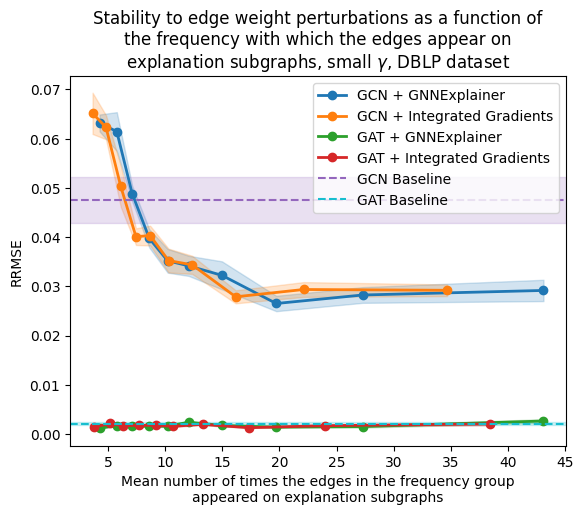

In [103]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small_edge_weights.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_small, GCN_IG_results_small_edge_weights.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small_edge_weights.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_small, GAT_IG_results_small_edge_weights.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_big.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_small.numpy(), "GAT Baseline", colors[5])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to edge weight perturbations as a function of\nthe frequency with which the edges appear on\nexplanation subgraphs, small $\\gamma$, DBLP dataset')
plt.show()

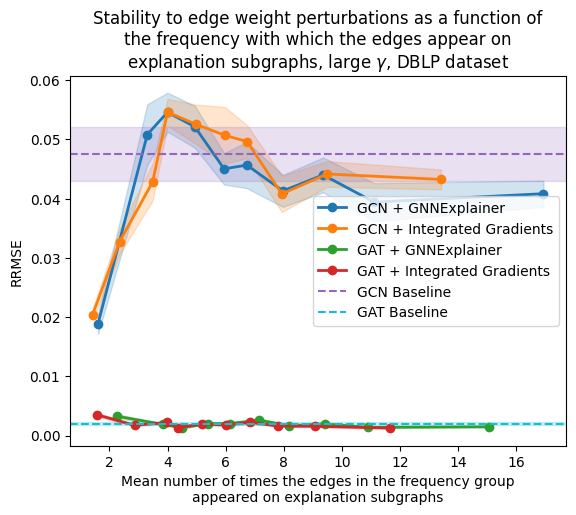

In [104]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big_edge_weights.numpy(), 'GCN + GNNExplainer', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_big, GCN_IG_results_big_edge_weights.numpy(), 'GCN + Integrated Gradients', colors[1])
plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big_edge_weights.numpy(), 'GAT + GNNExplainer', colors[2])
plot_with_confidence_intervals(GAT_IG_avg_freq_big, GAT_IG_results_big_edge_weights.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_baseline(GCN_baseline_big.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_big.numpy(), "GAT Baseline", colors[5])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to edge weight perturbations as a function of\nthe frequency with which the edges appear on\nexplanation subgraphs, large $\\gamma$, DBLP dataset')
plt.show()

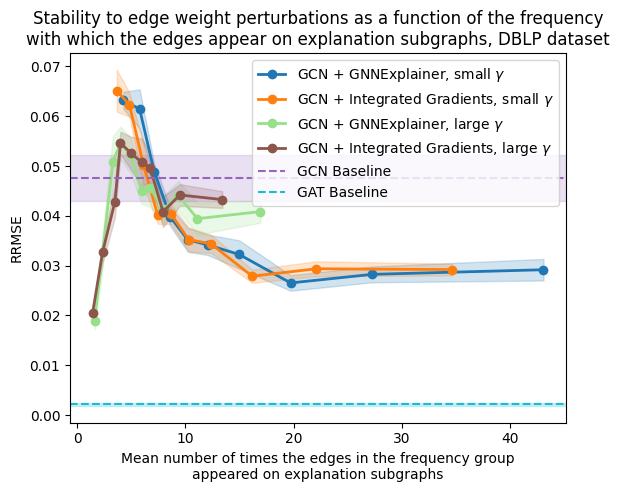

In [114]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf', '#98df8a', '#8c564b']

plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small_edge_weights.numpy(), 'GCN + GNNExplainer, small $\\gamma$', colors[0])
plot_with_confidence_intervals(GCN_IG_avg_freq_small, GCN_IG_results_small_edge_weights.numpy(), 'GCN + Integrated Gradients, small $\\gamma$', colors[1])
# plot_with_confidence_intervals(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small_edge_weights.numpy(), 'GAT + GNNExplainer', colors[2])
# plot_with_confidence_intervals(GAT_IG_avg_freq_small, GAT_IG_results_small_edge_weights.numpy(), 'GAT + Integrated Gradients', colors[3])
plot_with_confidence_intervals(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big_edge_weights.numpy(), 'GCN + GNNExplainer, large $\\gamma$', colors[6])
plot_with_confidence_intervals(GCN_IG_avg_freq_big, GCN_IG_results_big_edge_weights.numpy(), 'GCN + Integrated Gradients, large $\\gamma$', colors[7])
plot_baseline(GCN_baseline_big.numpy(), "GCN Baseline", colors[4])
plot_baseline(GAT_baseline_small.numpy(), "GAT Baseline", colors[5])

plt.legend()
plt.xlabel('Mean number of times the edges in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to edge weight perturbations as a function of the frequency\nwith which the edges appear on explanation subgraphs, DBLP dataset')
plt.show()

P-value for Edge removal DBLP, GCN + GNNExplainer, small $\gamma$: 0.023472516367494225
P-value for Edge removal DBLP, GCN + Integrated Gradients, small $\gamma$: 0.0044604693140455265
P-value for Edge removal DBLP, GAT + GNNExplainer, small $\gamma$: 0.023925203728334513
P-value for Edge remvoval DBLP, GAT + Integrated Gradients, small $\gamma$: 0.028750366400511033


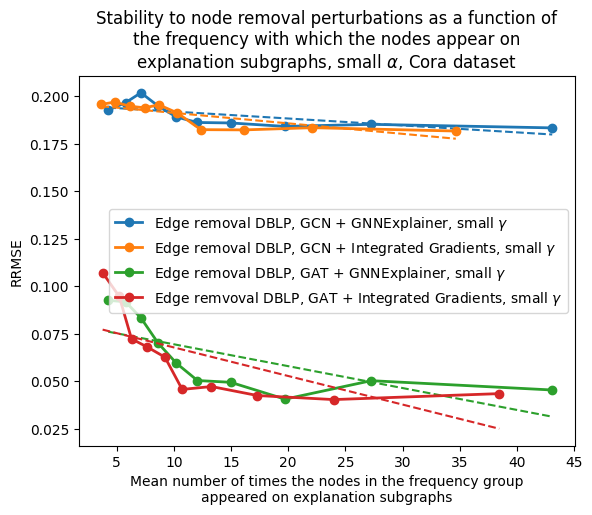

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, linregress

def best_fit(avg_freq, results, label, color):
    mean_values = np.mean(results, axis=1)

    slope, intercept, r_value, p_value_linear, std_err = linregress(avg_freq, mean_values)

    best_p_value = p_value_linear
    fit_line = slope * np.array(avg_freq) + intercept

    plt.plot(avg_freq, mean_values, label=label, color=color, linewidth=2, marker='o')
    plt.plot(avg_freq, fit_line, linestyle='--', color=color)

    print(f"P-value for {label}: {best_p_value}")

plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

best_fit(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small.numpy(), 'Edge removal DBLP, GCN + GNNExplainer, small $\\gamma$', colors[0])
best_fit(GCN_IG_avg_freq_small, GCN_IG_results_small.numpy(), 'Edge removal DBLP, GCN + Integrated Gradients, small $\\gamma$', colors[1])
best_fit(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small.numpy(), 'Edge removal DBLP, GAT + GNNExplainer, small $\\gamma$', colors[2])
best_fit(GAT_IG_avg_freq_small, GAT_IG_results_small.numpy(), 'Edge remvoval DBLP, GAT + Integrated Gradients, small $\\gamma$', colors[3])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, small $\\alpha$, Cora dataset')
plt.show()

P-value for Edge removal DBLP, GCN + GNNExplainer, large $\gamma$: 0.9529902910243297
P-value for Edge removal DBLP, GCN + Integrated Gradients, large $\gamma$: 0.27320304766072584
P-value for Edge removal DBLP, GAT + GNNExplainer, large $\gamma$: 0.003301251380087149
P-value for Edge removal DBLP, GAT + Integrated Gradients, large $\gamma$: 0.07155755291316439


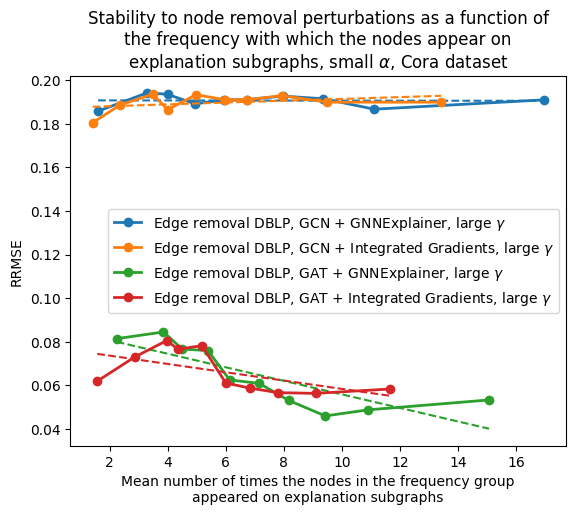

In [106]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

best_fit(GCN_GNNExplainer_avg_freq_big, GCN_GNNExplainer_results_big.numpy(), 'Edge removal DBLP, GCN + GNNExplainer, large $\\gamma$', colors[0])
best_fit(GCN_IG_avg_freq_big, GCN_IG_results_big.numpy(), 'Edge removal DBLP, GCN + Integrated Gradients, large $\\gamma$', colors[1])
best_fit(GAT_GNNExplainer_avg_freq_big, GAT_GNNExplainer_results_big.numpy(), 'Edge removal DBLP, GAT + GNNExplainer, large $\\gamma$', colors[2])
best_fit(GAT_IG_avg_freq_big, GAT_IG_results_big.numpy(), 'Edge removal DBLP, GAT + Integrated Gradients, large $\\gamma$', colors[3])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, small $\\alpha$, Cora dataset')
plt.show()

P-value for Edge weights, GCN + GNNExplainer, small $\gamma$: 0.030995917635125898
P-value for Edge weights, GCN + Integrated Gradients, small $\gamma$: 0.01862211878629147
P-value for Edge weights, GAT + GNNExplainer, small $\gamma$: 0.08615144551859295
P-value for Edge weights, GAT + Integrated Gradients, small $\gamma$: 0.5085642223081995


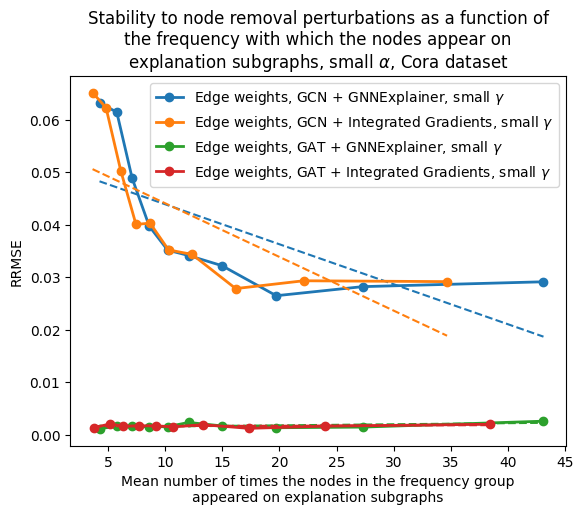

In [107]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

best_fit(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_small_edge_weights.numpy(), 'Edge weights, GCN + GNNExplainer, small $\\gamma$', colors[0])
best_fit(GCN_IG_avg_freq_small, GCN_IG_results_small_edge_weights.numpy(), 'Edge weights, GCN + Integrated Gradients, small $\\gamma$', colors[1])
best_fit(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_small_edge_weights.numpy(), 'Edge weights, GAT + GNNExplainer, small $\\gamma$', colors[2])
best_fit(GAT_IG_avg_freq_small, GAT_IG_results_small_edge_weights.numpy(), 'Edge weights, GAT + Integrated Gradients, small $\\gamma$', colors[3])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, small $\\alpha$, Cora dataset')
plt.show()

P-value for Edge weights, GCN + GNNExplainer, large $\gamma$: 0.8361183925411342
P-value for Edge weights, GCN + Integrated Gradients, large $\gamma$: 0.5832058855445043
P-value for Edge weights, GAT + GNNExplainer, large $\gamma$: 0.14937055739859637
P-value for Edge weights, GAT + Integrated Gradients, large $\gamma$: 0.10258091171479483


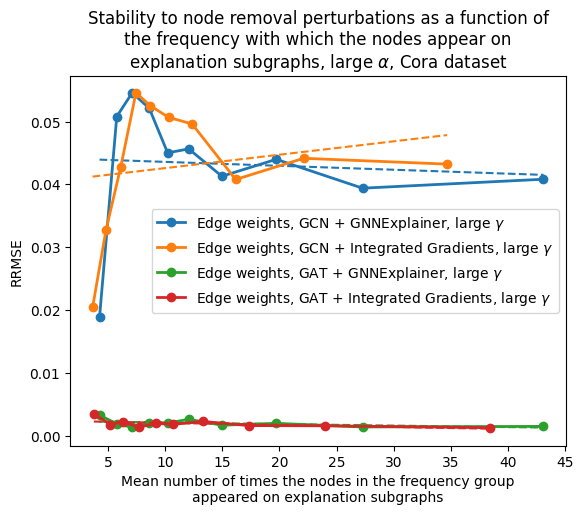

In [108]:
plt.figure()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']

best_fit(GCN_GNNExplainer_avg_freq_small, GCN_GNNExplainer_results_big_edge_weights.numpy(), 'Edge weights, GCN + GNNExplainer, large $\\gamma$', colors[0])
best_fit(GCN_IG_avg_freq_small, GCN_IG_results_big_edge_weights.numpy(), 'Edge weights, GCN + Integrated Gradients, large $\\gamma$', colors[1])
best_fit(GAT_GNNExplainer_avg_freq_small, GAT_GNNExplainer_results_big_edge_weights.numpy(), 'Edge weights, GAT + GNNExplainer, large $\\gamma$', colors[2])
best_fit(GAT_IG_avg_freq_small, GAT_IG_results_big_edge_weights.numpy(), 'Edge weights, GAT + Integrated Gradients, large $\\gamma$', colors[3])

plt.legend()
plt.xlabel('Mean number of times the nodes in the frequency group\nappeared on explanation subgraphs')
plt.ylabel('RRMSE')
plt.title('Stability to node removal perturbations as a function of\nthe frequency with which the nodes appear on\nexplanation subgraphs, large $\\alpha$, Cora dataset')
plt.show()